In [ ]:
import pandas as pd
import numpy as np
import plotnine as p
import statsmodels.api as sm
import statsmodels.formula.api as smf

import os
from operator import itemgetter
import warnings

import fsspec
import json
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
test_run = bool(os.environ.get("TEST_RUN", False))  # used by testing to run the notebook as a script


In [ ]:
# Load the Sleep Data
sleep_data_path = 'Sleep_data.xlsx'
df = pd.read_excel(sleep_data_path)

# Display the first few rows of the dataframe to understand its structure
df.head()


,Day,Month,Weekday,DATE,SLEEP_SCORE,HOURS_OF_SLEEP,REM_SLEEP,DEEP_SLEEP,HEART_RATE_BELOW_RESTING,SLEEP_TIME,Steps
0,1,November,Monday,2021-11-01,88.0,08:06:00,0.20,0.13,0.84,10:41pm - 7:54am,12643
1,2,November,Tuesday,2021-11-02,83.0,07:57:00,0.12,0.18,0.90,10:40pm - 7:55am,6958
2,3,November,Wednesday,2021-11-03,81.0,07:06:00,0.13,0.22,0.93,11:03pm - 7:16am,12126
3,4,November,Thursday,2021-11-04,86.0,07:04:00,0.19,0.17,0.97,10:55pm - 6:56am,11362
4,5,November,Friday,2021-11-05,81.0,09:24:00,0.17,0.15,0.66,10:14pm - 9:01am,6420


In [ ]:
!pip install stargazer

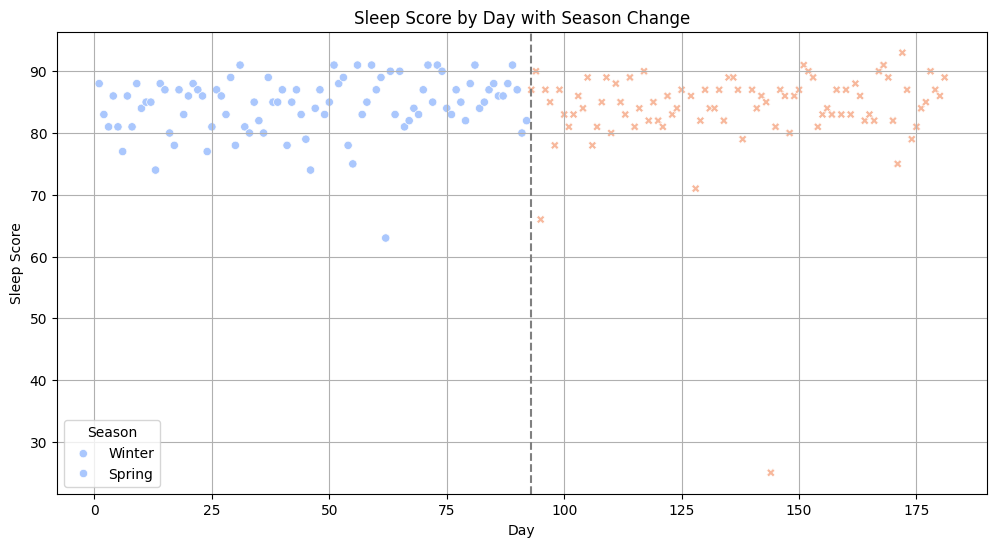

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Clean the NAs in the data frame
df = df.dropna(subset=['SLEEP_SCORE'])

# Create a binary variable for season: 0 for Winter (Day=1-92), 1 for Spring (Day=93-181)
df['Season'] = (df['Day'] >= 93).astype(int)

# Plotting
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Day', y='SLEEP_SCORE', hue='Season', data=df, palette='coolwarm', style='Season', markers=True)
plt.axvline(x=93, color='grey', linestyle='--', label='Start of Spring')
plt.title('Sleep Score by Day with Season Change')
plt.xlabel('Day')
plt.ylabel('Sleep Score')
plt.legend(title='Season', labels=['Winter', 'Spring'])
plt.grid(True)
plt.show()


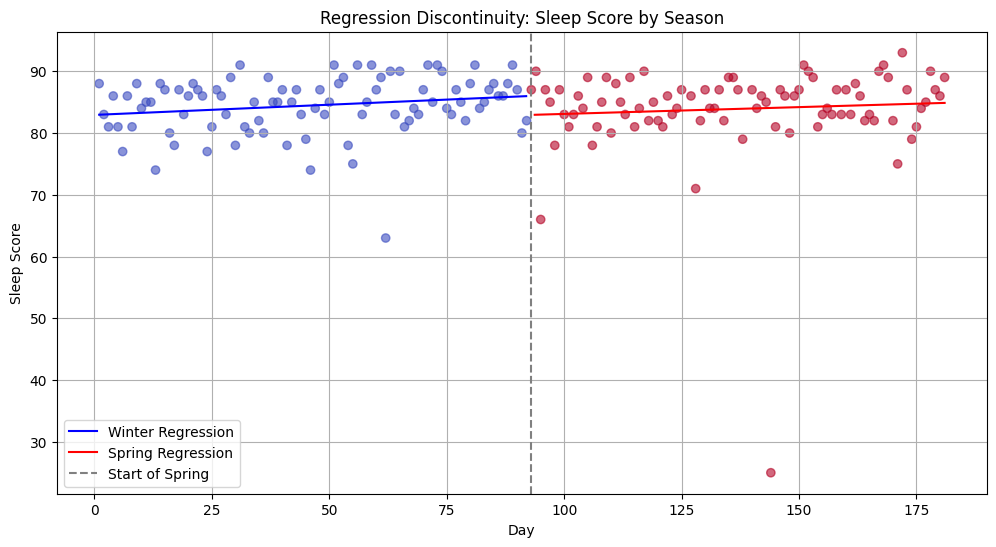

-3.0675216979097826

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare the data for regression
# Independent variable (centered around the cutoff to improve numerical stability)
X = df['Day'] - 93
# Dependent variable
Y = df['SLEEP_SCORE']

# Split the data based on the season
X_winter = X[df['Day'] < 93].values.reshape(-1, 1)
Y_winter = Y[df['Day'] < 93]
X_spring = X[df['Day'] >= 93].values.reshape(-1, 1)
Y_spring = Y[df['Day'] >= 93]

# Fit linear regression models on either side of the cutoff
reg_winter = LinearRegression().fit(X_winter, Y_winter)
reg_spring = LinearRegression().fit(X_spring, Y_spring)

# Predictions for visualization
X_vis = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

Y_pred_winter = reg_winter.predict(X_vis[X_vis.flatten() < 0].reshape(-1, 1))
Y_pred_spring = reg_spring.predict(X_vis[X_vis.flatten() >= 0].reshape(-1, 1))


# Plotting the results
plt.figure(figsize=(12, 6))
plt.scatter(df['Day'], Y, c=df['Season'], cmap='coolwarm', label=None, alpha=0.6)
plt.plot(X_vis[X_vis < 0] + 93, Y_pred_winter, color='blue', label='Winter Regression')
plt.plot(X_vis[X_vis >= 0] + 93, Y_pred_spring, color='red', label='Spring Regression')
plt.axvline(x=93, color='grey', linestyle='--', label='Start of Spring')
plt.title('Regression Discontinuity: Sleep Score by Season')
plt.xlabel('Day')
plt.ylabel('Sleep Score')
plt.legend()
plt.grid(True)
plt.show()

# Estimate of the discontinuity
discontinuity_estimate = reg_spring.intercept_ - reg_winter.intercept_
discontinuity_estimate

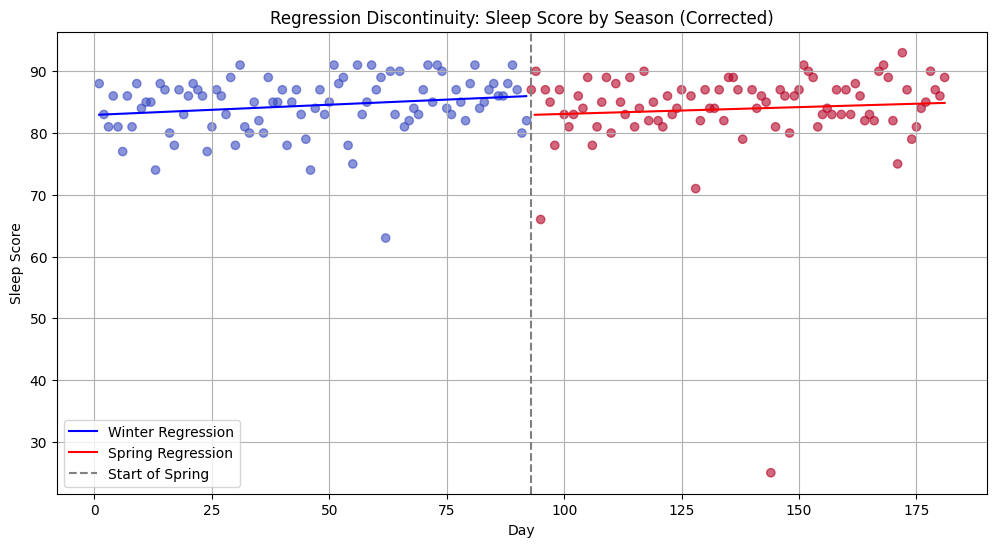

-3.0675216979097826

In [ ]:
# Correctly reshaping the X_vis_clean array for predictions
X_vis_reshaped = X_vis.reshape(-1, 1)

# Recalculating predictions with the correctly reshaped array
Y_pred_winter_clean = reg_winter.predict(X_vis_reshaped[X_vis_reshaped.flatten() < 0])
Y_pred_spring_clean = reg_spring.predict(X_vis_reshaped[X_vis_reshaped.flatten() >= 0])

# Re-plotting the results with the corrected data
plt.figure(figsize=(12, 6))
plt.scatter(df['Day'], Y, c=df['Season'], cmap='coolwarm', label=None, alpha=0.6)
plt.plot(X_vis_reshaped[X_vis_reshaped.flatten() < 0] + 93, Y_pred_winter_clean, color='blue', label='Winter Regression')
plt.plot(X_vis_reshaped[X_vis_reshaped.flatten() >= 0] + 93, Y_pred_spring_clean, color='red', label='Spring Regression')
plt.axvline(x=93, color='grey', linestyle='--', label='Start of Spring')
plt.title('Regression Discontinuity: Sleep Score by Season (Corrected)')
plt.xlabel('Day')
plt.ylabel('Sleep Score')
plt.legend()
plt.grid(True)
plt.show()

# Recalculate the estimate of the discontinuity with the corrected data
discontinuity_estimate_corrected = reg_spring.intercept_ - reg_winter.intercept_
discontinuity_estimate_corrected
